In [1]:
!pip uninstall -y numpy
!pip install numpy==1.25.2 --quiet
!pip install mediapipe==0.10.8 opencv-python --quiet


Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.7.1 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.2 which is incompatible.
blosc2 3.6.1 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
arviz 0.22.0 requires numpy>=1.26.0, but you have numpy 1.25.2 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


In [2]:
from google.colab import files
uploaded = files.upload()


Saving boxing.mp4 to boxing (2).mp4


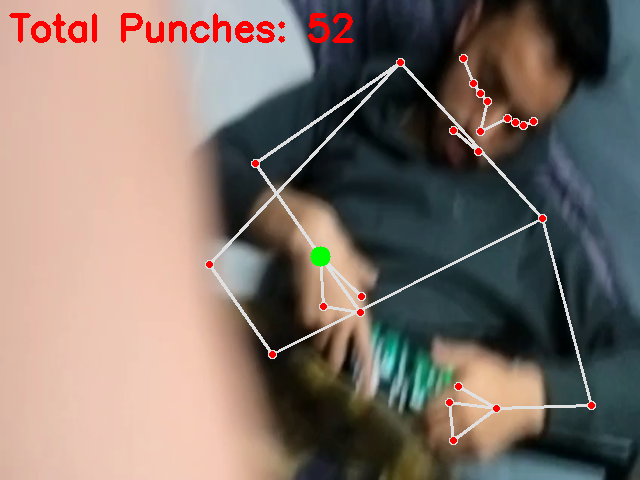

In [4]:
import cv2
import mediapipe as mp
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

def calc_velocity(p1, p2):
    return np.linalg.norm(np.array(p2) - np.array(p1))

punch_count = 0
threshold_velocity = 15  # lower for more sensitivity
cooldown_frames = 5
cooldown_counter = 0

last_right_wrist = None

cap = cv2.VideoCapture('boxing.mp4')
frame_skip = 2
frame_id = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_id += 1
    if frame_id % frame_skip != 0:
        continue

    frame = cv2.resize(frame, (640, 480))
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)

    if cooldown_counter > 0:
        cooldown_counter -= 1

    if results.pose_landmarks:
        right_wrist = results.pose_landmarks.landmark[16]
        h, w, _ = frame.shape
        wrist_coords = (int(right_wrist.x * w), int(right_wrist.y * h))

        if last_right_wrist is not None:
            velocity = calc_velocity(wrist_coords, last_right_wrist)

            if velocity > threshold_velocity and cooldown_counter == 0:
                punch_count += 1
                cooldown_counter = cooldown_frames

        last_right_wrist = wrist_coords
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        cv2.circle(frame, wrist_coords, 10, (0, 255, 0), -1)

    cv2.putText(frame, f'Total Punches: {punch_count}', (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

    clear_output(wait=True)
    cv2_imshow(frame)

cap.release()
